In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import numpy as np

positions=list(range(1,238))
positions_str=list(map(str,positions))
my_header= ["row_names"] + positions_str

def r_file(filename):
    return pd.read_csv(filename,sep="\t", header=None, names = my_header)

c_dms1 = r_file("./merged_ctrl_123.bit")
dms1 = r_file("./merged_DMS1_123.bit")
c_shape = r_file("./merged_T7_1M7_ctrl.bit")
shape = r_file("./merged_T7_1M7_123.bit")


In [2]:
#drop the first column which contains read_names so that you can later retype to int
def drop_fst_col(df):
    return df.drop(columns=df.columns[0],axis=1,inplace=True)
drop_fst_col(c_dms1)
drop_fst_col(dms1)
drop_fst_col(c_shape)
drop_fst_col(shape)


In [3]:
#replace NaN with twos, retype to integers / NaN are floats
def retype(df):
    return df.fillna(2).astype(int)
c_dms1 = retype(c_dms1)
dms1 = retype(dms1)
c_shape = retype(c_shape)
shape = retype(shape)


In [4]:
def count_all(df):
    ones = []
    zeros = []
    nans = []
    for col in df:
        values = df[col].value_counts()
        if 1 in values:   #this many ones are in the column      
            ones.append(values[1])
        else:
            ones.append(0) #there are no ones in the column
        if 0 in values: #this many zeros are in the column
            zeros.append(values[0])
        else:
            zeros.append(0)
        if 2 in values: #this many NaNs are in the column
            nans.append(values[2])
        else:
            nans.append(0)
    return(list(zip(ones, zeros, nans)))


In [5]:
def mutation_rate(df,ctrl):
    df_count = count_all(df)
    ctrl_count = count_all(ctrl)
    MR = []#MR stands for mutation rate
    MR_ctrl = []
    for t in df_count:
        MR.append(t[0] / (t[0] + t[1]))# ones / zeros_plus_ones
    for t in ctrl_count:
        MR_ctrl.append(t[0] / (t[0] + t[1]))
    
    #create dataframe with 3 columns position(1-237),MR,MR_ctrl
    position = list(range(1,238))
    dict = {"position": position, "MR" : MR, "MR_ctrl" : MR_ctrl}
    
    MR_df = pd.DataFrame(dict)
    
    MR_df["raw_reactivity"] = (MR_df["MR"] - MR_df["MR_ctrl"]) / (1 - MR_df["MR_ctrl"])
    MR_df["raw_reactivity_masked"] = MR_df["raw_reactivity"]
    MR_df["raw_reactivity_masked"].mask(MR_df["raw_reactivity"]<(-0.001),0,inplace=True)   
    
    NAs = []
    for i in MR_df["raw_reactivity"]:
        if i < -0.001:
            NAs.append(True)
        else:
            NAs.append(False)
    MR_df["is_excluded_point"] = NAs 
    
    scaler = MinMaxScaler()
    MR_df["normalized"] = scaler.fit_transform(MR_df[["raw_reactivity_masked"]])
    MR_df["normalized"].mask(MR_df["raw_reactivity"]<(-0.001),0,inplace=True)#change the normalized to 0 at positions with background 

    col = []
    export = []
    category = []
    for val in MR_df["normalized"]:
        if val <= 0.1:
            col.append("black")
            export.append(1)
            category.append("low")
        elif val <= 0.25:
            col.append("orange")
            export.append(2)
            category.append("intermediate")
        else:
            col.append("red")
            export.append(3)
            category.append("high")
    MR_df["col"] = col
    MR_df["export"] = export
    MR_df["category"] = category

    MR_df.loc[MR_df["is_excluded_point"]==True,"export"] = -999
    MR_df.loc[MR_df["is_excluded_point"]==True,"category"] = np.nan
    MR_df["normalized_NAs"] = MR_df["normalized"]
    MR_df.loc[MR_df["is_excluded_point"]==True,"normalized_NAs"] = -999
    
    return(MR_df)

MR_dms1 = mutation_rate(dms1,c_dms1)
MR_shape = mutation_rate(shape,c_shape)


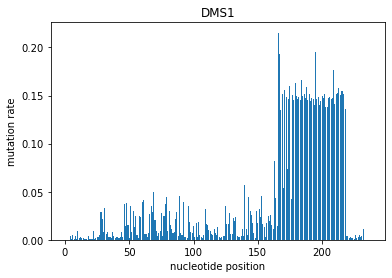

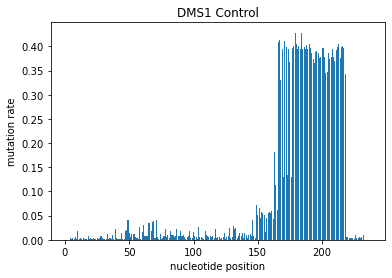

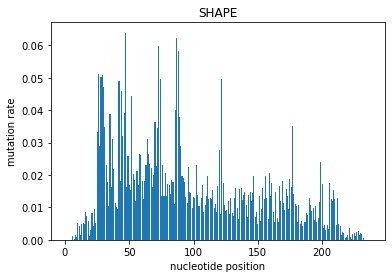

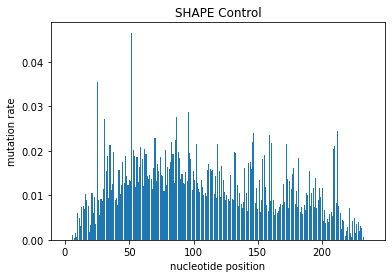

In [6]:
def plot_MR(df,title):
    plt.bar(df["position"],df["MR"])
    plt.xlabel("nucleotide position")
    plt.ylabel("mutation rate")
    plt.title(title)
    plt.show()

    plt.bar(df["position"],df["MR_ctrl"])
    plt.xlabel("nucleotide position")
    plt.ylabel("mutation rate")
    plt.title(title + " Control")
    plt.show()
plot_MR(MR_dms1,"DMS1")
plot_MR(MR_shape,"SHAPE")

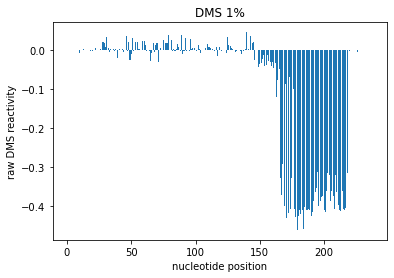

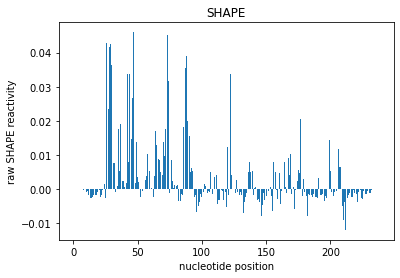

In [7]:
def plot_raw(df,title,method):
    plt.bar(df["position"],df["raw_reactivity"])
    plt.xlabel("nucleotide position")
    plt.ylabel("raw " + method + " reactivity")
    plt.title(title)
    plt.show()
plot_raw(MR_dms1,"DMS 1%","DMS")
plot_raw(MR_shape,"SHAPE", "SHAPE")

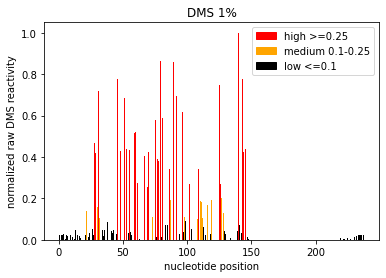

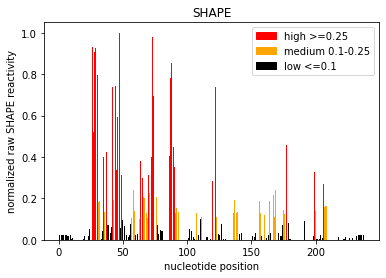

In [8]:
def plot_normalized(df, title, method):
    plt.bar(df["position"], df["normalized"],color = df["col"])
    plt.xlabel("nucleotide position")
    plt.ylabel("normalized raw " + method +" reactivity")
    plt.title(title)
    
    colors = {'high >=0.25':'red', 'medium 0.1-0.25':'orange', "low <=0.1":"black"}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels,loc="upper right")
    plt.savefig(method + "_reactivity_profile.svg", dpi='figure', format="svg")
    plt.show()

plot_normalized(MR_dms1,"DMS 1%","DMS")
plot_normalized(MR_shape,"SHAPE", "SHAPE")



In [9]:
def export(df, method):
    filename = method + "_reactivity_colors_continous.txt"
    f = open(filename, "w")
    for i in df["normalized_NAs"]:
        f.write(str(i)+"\n")
    f.close()
    filename = method + "_reactivity_colors_withNAs.txt"
    f = open(filename, "w")
    for i in df["export"]:
        f.write(str(i)+"\n")
    f.close()
export(MR_dms1,"dms1")
export(MR_shape,"shape")

In [28]:
dict = {"position" : MR_dms1["position"],"category_dms1":MR_dms1["category"],"category_shape":MR_shape["category"]}
df = pd.DataFrame(dict)
df.loc[max(df.index)+1,:] =np.nan
df.loc[max(df.index)+1,:] =np.nan
df.loc[max(df.index)+1,:] =np.nan


df["category_shape"] = df["category_shape"].shift(3)
s="gggaccaauuccagagcuggGGAGGCCUAAUCGUGGGUGUGGGGUUAUCUUCUCGCCCUCAACCCUAAACCUGGUCGCAAUCUGUGCCUAUUCUUGAAGGAGAGUUUUUCCAGUGGCUUACUCCUCAAACCAAAGCCCUGAUGCCAGGGUCUCACUGCUUCGGUCUAACGAUGAGCCUGUGGGGUGAGAGUGUCUCGGCACUUCUCACGAGUCCCGGGcaaucgggucgccuccuuuuac"
df["sequence"] = list(s)
df["are_in_the_same_category"] = np.where(df["category_dms1"]==df["category_shape"],True,False)
df.to_csv("reactivity.txt")

In [ ]:

df.to_csv("reactivity.txt")